# INF421 - Unblock me
**Elliot THOREL & Hubert LEROUX**

**TODO**

- regarder si la table de hachage est uniformément rempli est bien remplie grâce à <code>max_items_in_one_bucket</code>
- mise en valeur des résultats
- regarder si on n'a pas trop de lignes de code vis à vis de ce qui est attendu -> faire un choix
- uniformiser français / anglais
- faire les questions d'études de complexité
- supprimer seen et se servir seulement de antécédent

## Introduction

In [1]:
import os
import queue
import heapq
import time
from matplotlib import pyplot as plt

examples_dir = os.path.join("..", "examples")

## Setting up the game

Le jeu est encodé selon le format suivant : 

```text
6
8
1 h 2 2 3
2 h 2 1 1
3 h 2 5 5
4 h 3 3 6
5 v 3 6 1
```

**Question 1** - Check if the configuration is valid and initializes a rush hour game.

To check if the game is valid, we will put the each car on a board one after another. If all the cars can fit, then it is a valide configuration. 
Therefore we will create during the process a board that will be useful later. Void cases will be set to 0.
Additionnaly, we will put our cars in a dictionnary list.


In [2]:
def get_input():
    """
    Get the input from console 
    :return: the input
    @param n: the size of the grid
    @param nb_cars: the number of cars
    @param cars: the list of cars (dict list)
    """
    n = int(input())
    nb_cars = int(input())
    cars = []
    for _ in range(nb_cars):
        line = input().split()
        cars.append({"id_car" : int(line[0]), "orientation" : line[1], "length":int(line[2]), "x_topleft" : int(line[3])-1, "y_topleft" : int(line[4])-1})

    return n, cars # pas besoin de renvoyer nb_cars, on peut le calculer avec len(cars)


def get_input_from_file(file):
    """
    Get the input from file
    :return: the input
    @param n: the size of the grid
    @param nb_cars: the number of cars
    @param cars: the list of cars (dict list)
    """
    with open(file, 'r') as f:
        n = int(f.readline().strip())
        nb_cars = int(f.readline().strip())
        cars = []
        for _ in range(nb_cars):
            line = f.readline().strip().split()
            cars.append({"id_car" : int(line[0]), "orientation" : line[1], "length":int(line[2]), "x_topleft" : int(line[3])-1, "y_topleft" : int(line[4])-1})

    return n, cars

In [3]:
def is_point_in_grid(point, n):
    """
    Check if a point is in the grid
    :param point: tuple (x, y) representing the point
    :param n: size of the grid
    :return: True if the point is in the grid, False otherwise
    """
    return point[0] >= 0 and point[0] < n and point[1] >= 0 and point[1] < n

def cars_into_grid(n, cars):
    """
    Set the game
    1) Check that the configuration is correct
    2) Convert the grid encoding from a list of cars into a matrix form
    :param n: the size of the grid
    :param cars: the list of cars (dict list)
    :return: a tuple (bool, grid) where bool indicates if the configuration is correct and grid is the matrix form of the grid
    """
    def add_car(n, grid, car):
        """
        Add a car to the grid
        :param n: the size of the grid
        :param grid: the grid
        :param car: the car to add
        :return: True if the car can be added, False otherwise
        """
        if not is_point_in_grid((car["x_topleft"], car["y_topleft"]), n):
            return False  # the first point is not even in the grid, no need to go further
        
        # Differentiate based on the orientation of the car
        if car["orientation"] == "h":  # horizontal
            if not is_point_in_grid((car["x_topleft"] + car["length"] - 1, car["y_topleft"]), n):
                return False  # the car will not fit
            for i in range(car["length"]):
                if grid[car["y_topleft"]][car["x_topleft"] + i] != 0:  # there is already a car
                    return False
                grid[car["y_topleft"]][car["x_topleft"] + i] = car["id_car"]
        else:  # the car is vertical
            if not is_point_in_grid((car["x_topleft"], car["y_topleft"] + car["length"] - 1), n):
                return False
            for i in range(car["length"]):
                if grid[car["y_topleft"] + i][car["x_topleft"]] != 0:  # there is already a car
                    return False
                grid[car["y_topleft"] + i][car["x_topleft"]] = car["id_car"]
        return True  # the car was set correctly

    grid = [[0 for _ in range(n)] for _ in range(n)]
    for car in cars:
        possible = add_car(n, grid, car)
        if not possible:
            return False, None 
    return True, grid
    
def set_game_from_file(file):
    """
    Set the game from a file
    :param file: the file containing the game configuration
    :return: the game state as a dictionary with keys "size", "cars", and "grid"
    """
    n, cars = get_input_from_file(file)
    b, grid = cars_into_grid(n, cars)
    if b:
        return {"size": n, "cars": cars, "grid": grid}
    else:
        print("The configuration is not correct")

# TEST
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)
print(game_state["grid"])

[[3, 3, 0, 0, 0, 8], [2, 0, 0, 4, 0, 8], [2, 1, 1, 4, 0, 8], [2, 0, 0, 4, 0, 0], [6, 0, 0, 0, 7, 7], [6, 0, 5, 5, 5, 0]]


**Question 2** - Affichage de la grille

In [4]:
def show_grid(grid):
    """
    Display the grid in a readable format.
    
    :param grid: List of lists representing the grid.
    """
    max_id_car = max(max(line) for line in grid)
    nb_digits = len(str(max_id_car))
    for line in grid:
        print('|' + '|'.join('%0*d' % (nb_digits, cell) if cell != 0 else '_'*nb_digits for cell in line) + '|')


# TEST
file=os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)
show_grid(game_state["grid"])

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|




## Solving the game

### Computing the length of a shortest solution

**Question 3** - Brute force algorithm

Nous pour trouver la solution, nous allons parcourir bêtement l'ensemble des solutions à l'aide d'un parcours en largeur (BFS). Nous aurons donc besoin d'une file de priorité (FIFO) et d'un set (implémenté sous forme de table de hachage) pour marqué les configurations déjà vues. 


![pseudo-code q3](../question3_latex/pseudo_code_1.png)

Comme cela sera abordé à la question 7, il est possible, plutôt que de renvoyer True, de remonter à la solution en conservant les antécédents de chaque configuration dans une table de hachage.

**Question 4** - Get next moves

Pour déterminer les états accessibles, on peut utiliser :
- soit la liste des voitures
- soit la grille

L'avantage de la grille est qu'il est plus facile de voir directement les cases accessibles. L'avantage de la liste de voitures est qu'il est plus facile de la modifier. Nous allons stocker les listes de voitures dans la FIFO, mais à chaque fois nous créerons la grille de toute façon pour vérifier que la configuration est réglementaire. 

Pour chaque voiture, pour chaque direction, pour chaque delta possible dans cette direction on ajoute la configuration.
Pour savoir si la configuration est possible on utilise $\mathtt{set\_game}$ en avançant jusqu'à l'échec. C'est assez gourmand puisque qu'on reteste tout au lieu de ne vérifier qu'une seule case de la grille. Mais de toute façon si on voulait justement utiliser ces grilles il faudrait les recréer à chaque noeud d'un arbre. On est obligé de faire des copies ici puisque qu'on fait un parcours en largeur. Un parcours en profondeur nous aurait permis de travailler sur la même grille et gagner ainsi beaucoup d'espace. Mais on n'aurait pas trouvé forcément le chemin le plus court.  

**ETUDE DE LA COMPLEXITE**


Pistes d'amélioration :
- on n'a pas besoin de conserver toutes les informations sur les voitures, seules les coordonnées top-left suffisent pour suivre l'évolution suffisent. Cependant cette amélioration ne fait que changer la constante de la complexité.

In [5]:
def copy_game_state(game_state):
    """
    Create a deep copy of the game state.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: dict, a deep copy of the game state
    """
    n = game_state["size"]
    cars = game_state["cars"]
    grid = game_state["grid"]

    return {"size": n, "cars": [car.copy() for car in cars], "grid": [row[:] for row in grid]}


In [6]:
def get_next_moves(game_state):
    """
    Get all possible next moves from the current game state.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: list of dicts, each representing a new game state after a possible move
    """
    def get_next_moves_car(game_state, id_car):
        """
        Get all possible next moves for a specific car.
        
        :param game_state: dict, the current game state
        :param id_car: int, the ID of the car to move
        :return: list of dicts, each representing a new game state after a possible move of the car
        """
        def get_next_moves_car_in_one_direction(game_state, id_car, direction):
            """
            Get all possible next moves for a specific car in one direction.
            
            :param game_state: dict, the current game state
            :param id_car: int, the ID of the car to move
            :param direction: tuple, the direction to move the car (delta_x, delta_y)
            :return: list of dicts, each representing a new game state after a possible move of the car in the given direction
            """
            next_moves_car_one_direction = []
            new_game_state = copy_game_state(game_state)
            delta_x, delta_y = direction
            possible = True

            while possible:
                cars = new_game_state["cars"]
                car = cars[id_car]
                grid = new_game_state["grid"]
                n = new_game_state["size"]

                if delta_x + delta_y > 0:
                    point_left = (car["x_topleft"], car["y_topleft"])
                    point_to_check = (car["x_topleft"] + car["length"] * delta_x, car["y_topleft"] + car["length"] * delta_y)
                else:
                    point_left = (car["x_topleft"] - (car["length"] - 1) * delta_x, car["y_topleft"] - (car["length"] - 1) * delta_y)
                    point_to_check = (car["x_topleft"] + delta_x, car["y_topleft"] + delta_y)

                possible = is_point_in_grid(point_to_check, n) and grid[point_to_check[1]][point_to_check[0]] == 0

                if possible:
                    car["x_topleft"] += delta_x
                    car["y_topleft"] += delta_y
                    grid[point_left[1]][point_left[0]] = 0
                    grid[point_to_check[1]][point_to_check[0]] = car["id_car"]

                    next_moves_car_one_direction.append(new_game_state)
                    new_game_state = copy_game_state(new_game_state)

            return next_moves_car_one_direction

        next_moves_car = []
        car = game_state["cars"][id_car]
        if car["orientation"] == "h":
            next_moves_car.extend(get_next_moves_car_in_one_direction(game_state, id_car, (1, 0)))
            next_moves_car.extend(get_next_moves_car_in_one_direction(game_state, id_car, (-1, 0)))
        else:
            next_moves_car.extend(get_next_moves_car_in_one_direction(game_state, id_car, (0, 1)))
            next_moves_car.extend(get_next_moves_car_in_one_direction(game_state, id_car, (0, -1)))

        return next_moves_car

    next_moves = []
    for id_car in range(len(game_state["cars"])):
        next_moves.extend(get_next_moves_car(game_state, id_car))
    return next_moves

# TEST
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)
print("== CONFIGURATION INITIALE ==")
show_grid(game_state["grid"])
print()
for new_game_state in get_next_moves(game_state):
    show_grid(new_game_state["grid"])
    print()

== CONFIGURATION INITIALE ==
|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|_|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|_|_|3|3|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|_|_|_|3|3|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|3|3|_|_|_|8|
|2|_|_|_|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|4|7|7|
|6|_|5|5|5|_|

|3|3|_|4|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|_|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|_|5|5|5|

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|5|5|5|_|_|

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|7|7|_|
|6|_|5|5|5|_|

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|7|7|_|_|
|6|_|5|5|5|_|

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|7|7|_|_|_|
|6|_|5|5|5|_|

|3|3|_|_|_|_|
|2|_|_|4|_|8|
|2|1|1|4

**Question 5** - Implementation of the set

Python gives a general implementation with the $\mathtt{set}$ library. We will implement our own here. 
We will keep it simple. We will use a fixed size table of hashing. 

First let's have a upper bound for the number of possible configuration in order to have an idea of the size of the table.
Each car is blocked in his column or lign. Therefore, there are at most $\mathtt{n}$ possible configurations for each car (we do not bother with its length). So that gives us an upper bound $\mathcal{O}(n^\mathtt{nb\_cars})$ which his very large : with ten cars and 10 by 10 grid, it's $10^{10}$

Faisons plutôt une estimation du nombre d'états que nous comptons explorer. Disons un million, ou plutôt un nombre premier $P$ proche.

Maintenant, il faut réfléchir à une fonction de hachage efficace. C'est-à-dire qu'elle soit injective au maximum et que ses images soient bien réparties.

Pour cela il y a une idée assez simple. Notons $p_i$ le i-ème nombre premier et $d_i$ la distance de cette voiture à la frontière gauche (si elle est horizontale) en haut (si elle est verticale).

$$\displaystyle \mathtt{hash} = \prod_i^{\mathtt{nb\_cars}} p_i^{d_i+1} \quad [P]$$

Pour obtenir les $\tt nb_cars$ premiers nombres premiers on peut implémenter le crible d'Erathosthene. Mais ici cela revient à écraser une mouche avec une bombe atomique. Le nombre de voitures n'est pas le facteur limitant dans le problème. 

In [7]:
def generate_primes(n):
    """
    Generate the first n prime numbers
    :param n: the number of prime numbers to generate
    :return: a list of the first n prime numbers
    """
    primes = []
    candidate = 2
    while len(primes) < n:
        is_prime = True
        for prime in primes:
            if candidate % prime == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(candidate)
        candidate += 1
    return primes

# Example usage
n_primes = generate_primes(10)
print(n_primes)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]


In [8]:
def distance_top_left(car):
    """
    Get the distance from the top left corner
    :param car: the car
    :return: the distance
    """
    if car["orientation"] == "h":
        return car["x_topleft"]
    else:
        return car["y_topleft"]

In [9]:
def fast_exp_mod(base, exp, mod):
    """
    Compute (base^exp) % mod using fast exponentiation
    :param base: the base
    :param exp: the exponent
    :param mod: the modulus
    :return: (base^exp) % mod
    """
    result = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1:  # If exp is odd, multiply base with result
            result = (result * base) % mod
        exp = exp >> 1  # Divide exp by 2
        base = (base * base) % mod  # Square the base
    return result

# Example usage
print(fast_exp_mod(2, 10, 1000))  # Output: 24

24


In [10]:

class My_hash_table:
    """
    Hash table implementation to store the visited states
    
    keys and values are game_states (dict with attributes "cars")
    """
    def __init__(self, nb_cars=10, size=1000003):
        """
        Initialize the hash table.
        
        :param nb_cars: int, the number of cars in the game
        :param size: int, the size of the hash table
        """
        self.size = size
        self.nb_items = 0
        self.max_items_in_one_bucket = 0
        self.primes = generate_primes(nb_cars)
        self.table = [None for _ in range(size)]

    def __len__(self):
        """
        Get the number of items in the hash table.
        
        :return: int, the number of items in the hash table
        """
        return self.nb_items
    
    def hash(self, key):
        """
        Compute the hash value for a given key.
        
        :param key: dict, the game state
        :return: int, the hash value
        """
        h = 1
        for car in key["cars"]:
            d = distance_top_left(car)
            h = (h * fast_exp_mod(self.primes[car["id_car"]-1], d+1, self.size)) % self.size
        return h
    
    def get(self, key):
        """
        Get the value associated with a given key.
        
        :param key: dict, the game state
        :return: dict or None, the value associated with the key or None if the key is not found
        """
        h = self.hash(key)
        if self.table[h] is None:
            return None
        for k, v in self.table[h]:
            if key == k:
                return v
        return None
    
    def add(self, key, value):
        """
        Add a key-value pair to the hash table.
        
        :param key: dict, the game state
        :param value: dict, the value to associate with the key
        """
        h = self.hash(key)
        if self.table[h] is None:
            self.table[h] = [(key, value)]
        else:
            self.table[h].append((key, value))
        self.max_items_in_one_bucket = max(self.max_items_in_one_bucket, len(self.table[h]))
        self.nb_items += 1
    
    def contains(self, key):
        """
        Check if a key is in the hash table.
        
        :param key: dict, the game state
        :return: bool, True if the key is in the hash table, False otherwise
        """
        h = self.hash(key)
        if self.table[h] is None:
            return False
        for k, _ in self.table[h]:
            if key["cars"] == k["cars"]:
                return True
        return False
    
    def show_table(self):
        """
        Display the contents of the hash table.
        """
        for data in self.table:
            if data is not None:
                print(data)
    
# TEST
ht = My_hash_table()

file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)
ht.add(game_state, game_state)
ht.show_table()
print(ht.contains(game_state))  # Output: True

[({'size': 6, 'cars': [{'id_car': 1, 'orientation': 'h', 'length': 2, 'x_topleft': 1, 'y_topleft': 2}, {'id_car': 2, 'orientation': 'v', 'length': 3, 'x_topleft': 0, 'y_topleft': 1}, {'id_car': 3, 'orientation': 'h', 'length': 2, 'x_topleft': 0, 'y_topleft': 0}, {'id_car': 4, 'orientation': 'v', 'length': 3, 'x_topleft': 3, 'y_topleft': 1}, {'id_car': 5, 'orientation': 'h', 'length': 3, 'x_topleft': 2, 'y_topleft': 5}, {'id_car': 6, 'orientation': 'v', 'length': 2, 'x_topleft': 0, 'y_topleft': 4}, {'id_car': 7, 'orientation': 'h', 'length': 2, 'x_topleft': 4, 'y_topleft': 4}, {'id_car': 8, 'orientation': 'v', 'length': 3, 'x_topleft': 5, 'y_topleft': 0}], 'grid': [[3, 3, 0, 0, 0, 8], [2, 0, 0, 4, 0, 8], [2, 1, 1, 4, 0, 8], [2, 0, 0, 4, 0, 0], [6, 0, 0, 0, 7, 7], [6, 0, 5, 5, 5, 0]]}, {'size': 6, 'cars': [{'id_car': 1, 'orientation': 'h', 'length': 2, 'x_topleft': 1, 'y_topleft': 2}, {'id_car': 2, 'orientation': 'v', 'length': 3, 'x_topleft': 0, 'y_topleft': 1}, {'id_car': 3, 'orientati

In [11]:
class My_set(My_hash_table):
    """
    A set implementation based on My_hash_table to store unique game states.
    Inherits from My_hash_table and overrides the add method to store only keys.
    """
    def add(self, key):
        """
        Add a key to the set.
        
        :param key: dict, the game state to add
        """
        super().add(key, None)
    
# TEST
s = My_set()
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)
s.add(game_state)
print(s.contains(game_state))  # Output: True

True


**Question 6** - Implémentation

Il faut avant tout faire une fonction déterminant si la position est gagnante.

In [12]:
def is_winning(game_state):
    """
    Check if the current game state is a winning state.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: bool, True if the red car (car with id 1) has reached the right edge of the grid, False otherwise
    """
    cars = game_state["cars"]
    n = game_state["size"]
    
    return cars[0]["x_topleft"] == n - cars[0]["length"]

In [13]:
def brute_foce_BFS(game_state):
    """
    Perform a brute force Breadth-First Search (BFS) to solve the game.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: tuple, (int, int), the minimum number of moves to solve the game and the number of explored nodes, or (-1, int) if no solution is found
    """
    nb_cars = len(game_state["cars"])

    q = queue.Queue()
    q.put((0, game_state))

    seen = My_set(nb_cars)

    while q:
        depth, game_state = q.get()

        if seen.contains(game_state):  # if already processed, ...
            continue  # ... skip to the next

        seen.add(game_state)

        if is_winning(game_state):
            return depth, len(seen)
        
        for new_game_state in get_next_moves(game_state):
            if not seen.contains(new_game_state):
                q.put((depth+1, new_game_state))

    return -1, len(seen)

def brute_foce_BFS_from_file(file):
    """
    Perform a brute force Breadth-First Search (BFS) to solve the game from a file.
    
    :param file: str, the path to the file containing the game configuration
    :return: int, the minimum number of moves to solve the game or -1 if no solution is found
    """
    game_state = set_game_from_file(file)
    return brute_foce_BFS(game_state)

# TEST 

file = os.path.join(examples_dir, "GameP01.txt")
print(brute_foce_BFS_from_file(file)) 

(8, 1058)




### Reconstruction of the solution

**Question 7**

Il faut une nouvelle structure de données conservant l'antécédent de chaque solution. C'est ici que la structure clef-valeur de notre table de hachage va être utilisé.

On modifie également légèrement l'algorithme de la question 3. Plutôt que de vérifier si une configuration a déjà été parcourue au moment de son étude, on s'assure que chaque configuration n'entre dans la FIFO qu'une seule fois.

![pseudo-code q7](../question3_latex/pseudo_code_2.png)

In [14]:
def deballe_solution(antecedent, game_state):
    """
    Unpack the solution path from the antecedent hash table.

    :param antecedent: My_hash_table, the hash table storing the antecedents of each game state
    :param game_state: dict, the final game state from which to start unpacking the solution
    :return: list of dicts, the solution path from the initial state to the final state
    """
    solution = []
    while game_state is not None:
        solution.append(game_state)
        game_state = antecedent.get(game_state)
    return solution[::-1]

In [15]:
def brute_foce_BFS_with_solution(game_state):
    """
    Perform a brute force Breadth-First Search (BFS) to solve the game and return the solution path.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: tuple, (number of explored nodes, minimum number of moves to solve the game, solution path)
    """
    nb_cars = len(game_state["cars"])

    q = queue.Queue()
    q.put((0, game_state))

    antecedent = My_hash_table(nb_cars)
    antecedent.add(game_state, None)  # The initial state has no antecedent

    while q:
        depth, game_state = q.get()

        if is_winning(game_state):
            return len(antecedent) - q.qsize(), depth, deballe_solution(antecedent, game_state)
        
        for new_game_state in get_next_moves(game_state):
            if not antecedent.contains(new_game_state):
                antecedent.add(new_game_state, game_state)
                q.put((depth + 1, new_game_state))

    return -1, None, None

# TEST 
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

_, min_dist, solution = brute_foce_BFS_with_solution(game_state)
print(f"Nombre de coups minimum : {min_dist}")

for game_state in solution:
    print()
    show_grid(game_state["grid"])

Nombre de coups minimum : 8

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|_|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|2|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|_|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|2|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|6|_|_|4|_|_|
|6|_|_|_|7|7|
|_|_|5|5|5|_|

|2|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|6|_|_|4|_|_|
|6|_|_|_|7|7|
|5|5|5|_|_|_|

|2|3|3|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|6|_|_|4|_|_|
|6|7|7|_|_|_|
|5|5|5|_|_|_|

|2|3|3|_|_|8|
|2|_|_|_|_|8|
|2|1|1|_|_|8|
|6|_|_|4|_|_|
|6|7|7|4|_|_|
|5|5|5|4|_|_|

|2|3|3|_|_|_|
|2|_|_|_|_|_|
|2|1|1|_|_|_|
|6|_|_|4|_|8|
|6|7|7|4|_|8|
|5|5|5|4|_|8|

|2|3|3|_|_|_|
|2|_|_|_|_|_|
|2|_|_|_|1|1|
|6|_|_|4|_|8|
|6|7|7|4|_|8|
|5|5|5|4|_|8|




## Approach based on heuristics

### First steps with heuristics


**Question 8**

![pseudo-code q8](../question3_latex/pseudo_code_3.png)


**Commentaire sur l'algorithme**
L'algorithme est essentiellement le même qu'aux questions précédentes. La seule différence est que plutôt de stocker les noeuds à parcourir dans une FIFO, on les stocke dans une file de priorité qui nous permet de parcourir les noeuds par priorité croissante ($\mathtt{priorité}(s)=\mathtt{h}(s)+\mathtt{depth}(s)$).

**Choix d'implémentation**
Nous ne pouvons pas nous servir de l'astuce de la question 7 de gérer l'appartenance à $\mathtt{seen}$ lors de l'ajout à la file. Nous allons donc utiliser 2 tables de hachages en parallèle, une table $\mathtt{seen}$ et une table $\mathtt{antecedent}$.

Nous allons utiliser des tas pour gérer plus simplement les priorités. L'implémentation est assez facile avec des arbres binaires, mais on va utiliser ici celle de python. 

**Preuve de l'algorithme**

Pour commencer, la preuve de la *terminaison* est essentiellement la même que celle de l'algorithme de la question 3. Chaque configuration entre au maximum une fois dans la file et il y a un nombre fini d'état possible ce qui assure que l'algorithme se termine.

Maintenant, nous allons diviser la preuve de la *validité* en 2 étapes. Tous d'abord, nous allons montré que si une solution existe, une solution est trouvée par l'algorithme. Ensuite, nous allons montré que la solution renvoyée par l'algorithme minimise le nombre d'étapes.

1) Encore, une fois, la preuve est la même que pour l'algorithme de la question 3. Nous allons raisonné par l'absurde en supposons qu'il existe une solution et que l'algorithme ne l'a pas trouvé (il a donc vidé entièrement la file). Nous allons représenter la solution par la succession de ses états $(s_0, ..., s_k)$. On a ainsi $\forall i \in \llbracket 0, (k-1) \rrbracket, s_{i+1} \in \mathtt{next\_moves}(s_i)$.

Regardons les états qui sont entrés (et donc sortis!) de la file. Nécessairement, $s_0$ est entré dans la file et $s_k$ n'est pas entré (sinon une solution aurait été trouvé). On peut donc considérer le plus petit $i$ tel que $s_i$ soit entré dans la file mais pas $s_{i+1}$. L'existence d'un tel i est absurde car $s_i$ a nécessairement été pop et a donc obligatoirement ajouté $s_{i+1}$ à la file.

2) Ici, la preuve est similaire à celle qu'on pourrait faire pour l'algorithme de la question 3 mais on va devoir utiliser les propriétés de l'heuristique qui nous sont données.

Dans un premier temps, nous allons montré par induction structurelle les 2 propriétés suivantes:
- les noeuds sont toujours pop par priorité croissante
- lorsque l'algorihtme pop un noeud, la profondeur que l'algorithme a donné à ce noeud est sa vraie profondeur minimale.

*Initialisation*: Au début de l'algorihtme, il n'y a aucun noeud pop. Tout est donc bien vérifié
Après la première étape de l'algorithme, un seul noeud a été pop et donc l'ordre de pop a bien été respecté. Par ailleurs, le seul noeud ayant été pop est la configuration initiale et sa profondeur est bien 0.

*Hérédité*: On suppose que les n premiers noeuds ont bien été pop par priorité croissante et qu'il n'y a pas eu de mauvais assignement de profondeurs dans les noeuds qui ont déja été pop. Considérons ce qu'il se passe lorsque l'on pop le noeud suivant $s_{n+1}$. 
- Pour le premier critère, il suffit de vérifier que la priorité de $s_{n+1}$ est supérieure ou égale à la priorité du noeud précédemment pop $s_n$. Il y a 2 cas possibles:
    - soit $s_{n+1}$ n'est pas arrivé dans la file suite au pop de $s_n$. Dans ce cas avant le pop de $s_n$, les 2 états étaient dans la file de priorité et donc la priorité de $s_{n+1}$ est supérieure ou égale à la priorité de $s_n$. (sinon il aurait été pop à sa place)
    - soit s_{n+1} est arrivé dans la file suite au pop de $s_n$. Dans ce cas là, on a $\mathtt{depth}(s_{n+1})= \mathtt{depth}(s_{n}) + 1$ et la consistence de l'heuristique nous donne $\mathtt{h}(s_{n}) \le \mathtt{h}(s_{n + 1}) + 1$ (car $k_{s_{n},s_{n + 1}}=1)$. On a donc bien $\mathtt{priority}(s_{n}) \le \mathtt{priority}(s_{n + 1})$.   
- Pour le second critère, il suffit de vérifier qu'à $s_{n+1}$ a bien été assignée la bonne profondeur. 
Comme $s_{n+1} \ne s_0$, la profondeur de $s_{n+1}$ a été obtenue comme $\mathtt{depth}(s_{n+1}) = p + 1$ où $p = \mathtt{depth}(s')$ pour un certains $s'$ "voisin" de $s_{n+1}$ qui a déjà été pop. Par hypothèse de récurrence, la profondeur de $s'$ est correcte. $\mathtt{depth}(s_{n+1})$ est donc une borne sup de la vraie profondeur minimale de $s_{n+1}$.
    
    Raisonnons par l'absurde et supposons que la vraie profondeur $q$ de $s_{n+1}$ soit strictement inférieure à $p+1$. Il existe donc un chemin d'états $(c_0, ... ,c_q)$ tel que $c_0 = s_0$ et $c_q = s_{n+1}$. Pareillement à la pruve du premier critère, on peut considérer le plus petit i tel que $c_i$ ait été pop avant l'étape $n$ mais pas $c_{i+1}$. On a $\mathtt{priority}(c_{i+1})=\mathtt{depth}(c_{i})+1+\mathtt{h}(c_{i+1})$. Or par hypothèse de récurrence, la profondeure de $c_{i}$ est la vraie profondeure. Donc $\mathtt{depth}(c_{i}) \le i$. Par ailleurs, par consistence de l'heuristique, $\mathtt{h}(c_{i+1}) \le \mathtt{h}(c_{q}) +q-i-1$. On a donc $\mathtt{priority}(c_{i+1}) \le \mathtt{h}(c_{q}) +q = \mathtt{h}(s_{n + 1}) +q$

    Ceci signifie qu'à l'étape $n+1$, il y a dans la file un noeud $c_{i+1}$ avec une priorité inférieure à $\mathtt{h}(s_{n + 1}) +q$ mais que c'est le noeud $s_{n + 1}$ qui est pop avec une priorité supérieure de $\mathtt{h}(s_{n + 1}) + p$. Ceci est en contradiction avec le fonctionnement des files de priorité.

Ceci achève de démontrer par inductuction structurelle les 2 propriétés.

Pour conclure, nous allons considérer un algorithme similaire excepté qu'au lieu de s'arréter lorsqu'il trouve une solution, il continue jusqu'à avoir épuisé enitèrement la file de priorité puis renvoie la première solution trouvée. Il est clair que ce nouveau algorithme renvoie exactement le même résultat que l'ancien. De plus, la preuve ci-dessus permet également de montrer que cet algorithme valide les 2 propriétés énoncées.

Ces propriétés nous pemettent alors d'affirmer que parmi toutes les solutions trouvables par l'algorithme, l'algorithme va renvoyer celle de priorité minimum (première propriété). Or pour une solution, l'heuristique vaut 0, donc la priorité est égale à la profondeure calculée. La profondeur calculée est égale à la vraie profondeur (deuxième propriété). Donc l'algorithme renvoie bien une soultion de profondeur minimum.

**Avec l'heuristique nulle**

Avec une heuristique constante égale à 0, la priorité vaut toujours la profondeur. L'algorithme est donc très similaire à l'utilisation d'une FIFO (algorithme de la question 3). Il se peut cependant que pour une même profondeur, les états ne soient pas parcourus dans le même ordre selon l'implémentation de la file de priorité.



**Question 9**

A chaque mouvement, on ne peut déplacer qu'une voiture. En particulier, on ne peut donc changer le nombre de voitures bloquantes que de 1.

Avec deux états voisins $s$ et $s'$, on a donc $h(s) \le h(s')+1$. Par récurrence, on obtient que l'heuristique h est consistante.

**Implémentation des tas**

Voici un [lien](https://realpython.com/python-heapq-module/) sur l'implémentation d'un tas de priorité. 



Cependant, nous ne pouvons pas l'utiliser directement puisqu'il faut une clef de comparaison pour les données, dont nos configurations. Voici une [proposition](https://stackoverflow.com/questions/7803121/in-python-heapq-heapify-doesnt-take-cmp-or-key-functions-as-arguments-like-sor) pour enrober les fonctions. 




In [16]:
class My_Cars(tuple):
    """
    A class to represent a game configuration as a tuple.

    The tuple contains:
    - distance_heuristique: The heuristic distance.
    - profondeur: The depth of the game state.
    - game_state: The current game state.
    - antecedent: The antecedent of the game state.

    The class overrides the less than operator to compare based on the sum of distance_heuristique and profondeur.
    """
    def __lt__(self, other):
        return self[0] + self[1] < other[0] + other[1]

In [ ]:
def heuristic_BFS(game_state, heuristic = lambda x : 0):
    """
    Perform a heuristic Breadth-First Search (BFS) to solve the game.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :param heuristic: function, a heuristic function that takes a game state and returns a heuristic value
    :return: tuple, (number of explored nodes, minimum number of moves to solve the game, solution path)
    """
    nb_cars = len(game_state["cars"])

    q = [My_Cars((heuristic(game_state), 0, game_state, None))]
    heapq.heapify(q)

    seen = My_set(nb_cars)
    antecedent = My_hash_table(nb_cars)
    antecedent.add(game_state, None)  # The initial state has no antecedent

    while q:
        h, dist, game_state, antecedent_game_state = heapq.heappop(q)
        if not seen.contains(game_state):
            antecedent.add(game_state, antecedent_game_state)
            seen.add(game_state)  # Mark the state as seen

            if is_winning(game_state):
                solution = deballe_solution(antecedent, game_state)
                return (len(seen), dist, solution)
            
            for new_game_state in get_next_moves(game_state):
                heapq.heappush(q, My_Cars((heuristic(new_game_state), dist + 1, new_game_state, game_state)))

    return (-1, None, None)

# TEST 
for i in range(1,7):
    file = os.path.join(examples_dir, f"GameP{i:02}.txt")
    game_state = set_game_from_file(file)

    nb_explored, min_dist, solution = heuristic_BFS(game_state)
    print(f"Nombre de noeuds explorés : {nb_explored:,}")
    print(f"Nombre de coups minimum : {min_dist}")
    for game_state in solution:
        print()
        show_grid(game_state["grid"])

Nombre de noeuds explorés : 1,060
Nombre de coups minimum : 8

|3|3|_|_|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|_|_|3|3|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|2|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|2|_|3|3|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|_|_|_|4|_|_|
|6|_|_|_|7|7|
|6|_|5|5|5|_|

|2|_|3|3|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|_|_|_|4|_|_|
|6|7|7|_|_|_|
|6|_|5|5|5|_|

|2|_|3|3|_|8|
|2|_|_|4|_|8|
|2|1|1|4|_|8|
|6|_|_|4|_|_|
|6|7|7|_|_|_|
|_|_|5|5|5|_|

|2|_|3|3|_|_|
|2|_|_|4|_|_|
|2|1|1|4|_|_|
|6|_|_|4|_|8|
|6|7|7|_|_|8|
|_|_|5|5|5|8|

|2|_|3|3|_|_|
|2|_|_|4|_|_|
|2|1|1|4|_|_|
|6|_|_|4|_|8|
|6|7|7|_|_|8|
|5|5|5|_|_|8|

|2|_|3|3|_|_|
|2|_|_|_|_|_|
|2|1|1|_|_|_|
|6|_|_|4|_|8|
|6|7|7|4|_|8|
|5|5|5|4|_|8|

|2|_|3|3|_|_|
|2|_|_|_|_|_|
|2|_|_|_|1|1|
|6|_|_|4|_|8|
|6|7|7|4|_|8|
|5|5|5|4|_|8|
Nombre de noeuds explorés : 2,904
Nombre de coups minimum : 8

|02|__|__|06|06|06|
|02|__|__|07|__|11|
|01|01|__|07|08|11|
|03|03|03|__|08|11|
|__|__|05|__|09|09|
|04|04|05|

Implémentons maintenant la distance heuristique proposée par l'énoncé.

In [18]:
def number_cars_blocking(game_state):
    """
    Get the number of cars blocking the path of the main car.
    
    Note: All blocking cars are vertical; otherwise, the game is unsolvable.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: int, the number of cars blocking the path of the main car
    """
    cars = game_state["cars"]

    return sum(1 for car in cars[1:] if car["y_topleft"] <= cars[0]["y_topleft"] 
               and cars[0]["y_topleft"] < car["y_topleft"] + car["length"] 
               and cars[0]["x_topleft"] <= car["x_topleft"] and car["orientation"] == "v")

# TEST
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

print(number_cars_blocking(game_state))  # Output: 2

2


In [19]:
# TEST 
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

nb_explored, min_dist, solution = heuristic_BFS(game_state, number_cars_blocking)
print(f"Nombre de noeuds explorés : {nb_explored:,}")
print(f"Nombre de coups minimum : {min_dist}")

Nombre de noeuds explorés : 948
Nombre de coups minimum : 8


On remarque qu'on a exploré un peu moins de configurations. Comparons maintenant les deux algorithmes sur l'ensemble du jeu de données. 

In [20]:
heuristic_data = []
brute_foce_BFS_data = []

number_games = 10 # 40 max
for i in range(1,number_games+1):
    file = os.path.join(examples_dir, f"GameP{i:02}.txt")
    game_state = set_game_from_file(file)
    n=game_state["size"]
    
    start_time_heuristic = time.time()
    nb_explored_h, min_dist_h, _ = heuristic_BFS(game_state, number_cars_blocking)
    heuristic_data.append((nb_explored_h, min_dist_h, n, time.time()-start_time_heuristic))

    start_time_brute_force = time.time()
    nb_explored, min_dist, _ = brute_foce_BFS_with_solution(game_state)
    brute_foce_BFS_data.append((nb_explored, min_dist, n, time.time()-start_time_brute_force))
    

Affichons nos résultats sous une forme exploitable. On peut tracer par exemple le ratio du nombre de noeuds explorés grâce à l'algorithme heuristique contre celui du parcours en largeur en fonction du nombre de noeuds explorés par le parcours en largeur.

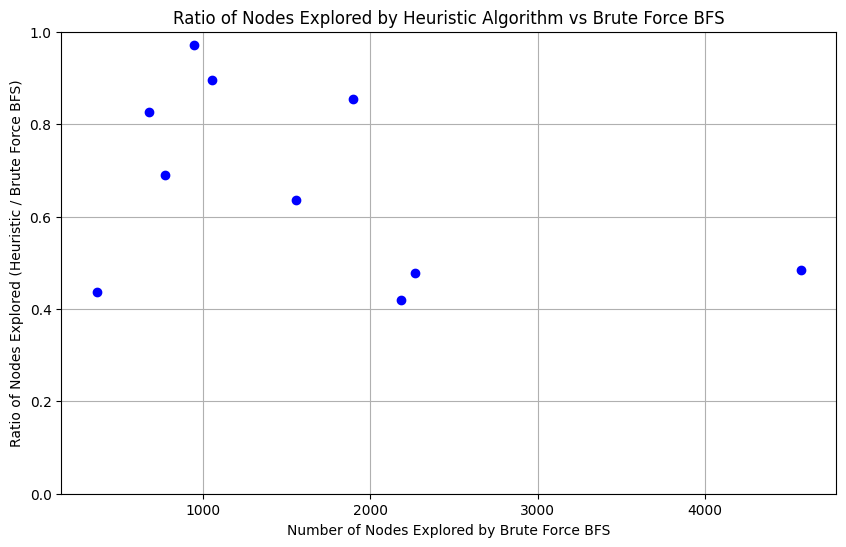

In [21]:
# Extract data
brute_force_nodes = [data[0] for data in brute_foce_BFS_data]
heuristic_nodes = [data[0] for data in heuristic_data]

# Calculate ratio
ratios = [h / b for h, b in zip(heuristic_nodes, brute_force_nodes)]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(brute_force_nodes, ratios, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Nodes Explored by Brute Force BFS')
plt.ylabel('Ratio of Nodes Explored (Heuristic / Brute Force BFS)')
plt.ylim(0, 1)
plt.title('Ratio of Nodes Explored by Heuristic Algorithm vs Brute Force BFS')
plt.grid(True)
plt.show()

Comme on peut le voir tous les ratios sont bien inférieurs à 1, parfois il explore jusqu'à deux fois moins de nœuds, mais parfois c'est assez similaire. Nous n'arrivons pas bien à discerner sur ce graphique dans quel cas l'heuristique est vraiment bonne. Cela doit dépendre de l'arrangement du jeu. 

Regardons les performances en temps.

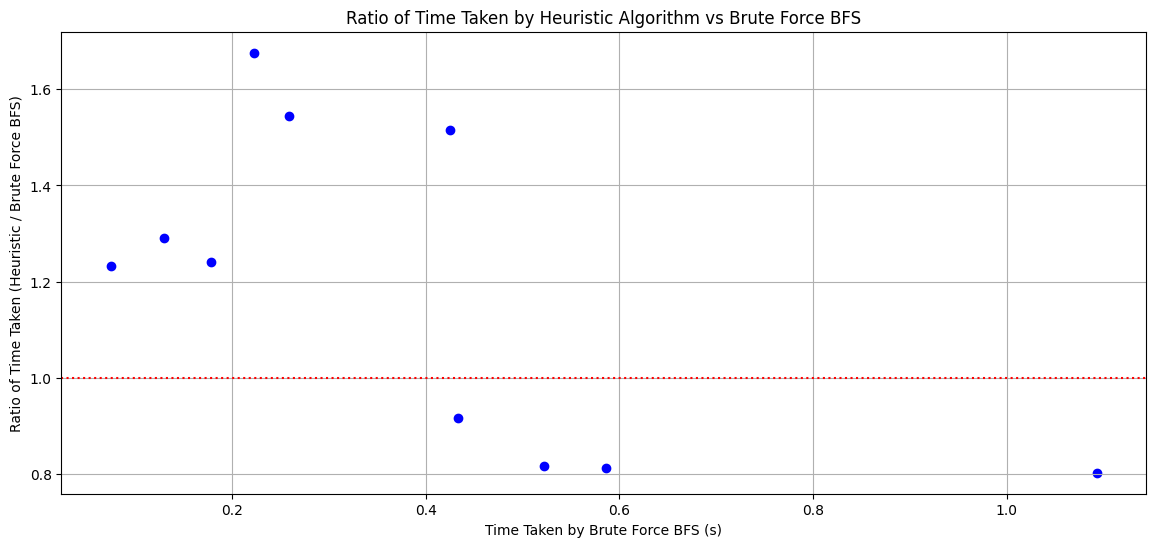

In [22]:
# Extract data
brute_force_times = [data[3] for data in brute_foce_BFS_data]
heuristic_times = [data[3] for data in heuristic_data]

# Calculate ratios
time_ratios = [h / b for h, b in zip(heuristic_times, brute_force_times)]

# Plot time ratios
plt.figure(figsize=(14, 6))

plt.scatter(brute_force_times, time_ratios, marker='o', linestyle='-', color='b')
plt.xlabel('Time Taken by Brute Force BFS (s)')
plt.ylabel('Ratio of Time Taken (Heuristic / Brute Force BFS)')
plt.title('Ratio of Time Taken by Heuristic Algorithm vs Brute Force BFS')
plt.axhline(y=1, color='r', linestyle=':')
plt.grid(True)


plt.show()

On voit que le calcul de la distance heuristique et l'implémentation en tas conduit également à des pertes en temps d'exécution qui ne sont pas toujours compensées par la diminution du nombre d'états visités. Trouver une bonne heuristique nécessitera donc de faire des compromis entre la qualité de l'heuristique et le temps nécessaire pour la calculer.



### New heuristics


Certaines heuristiques sont admissibles mais ont peu de chances d'être utiles. On peut penser par exemple à l'heuristique $h(s)=\mathtt{depth}(s)$ qui donne les mêmes résultats que l'heuristqiue nulle ou à $h(s)=- \mathtt{depth}(s)$ où tous les noeuds ont la même priorité et qui donne un algorithme très imprévisible.

Une autre heuristique possible serait de se servir de la distance de la voiture rouge à l'objectif. Cependant, comme il est possible de traverser toute la grille en un seul coup , cette distance doit être normalisé pour rester consistante.

In [23]:
def distance_to_goal(game_state):
    """
    Calculate the normalized distance of the red car (car with id 1) to the goal.
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: float, the normalized distance to the goal
    """
    cars = game_state["cars"]
    n = game_state["size"]
    return (n - cars[0]["length"] - cars[0]["x_topleft"]) / n

Cette distance a assez peu de chance d'être intéressante car elle ne respecte pas vraiment l'esprit du jeu. Il faut chercher à bouger un minimum de fois chaque voiture plutôt que de se rapprocher petit à petit.

Une autre idée est de s'inspirer de l'heuristique *number_cars_blocking* et de l'améliorer pour essayer de trouver une bonne estimation du nombre de voitures à déplacer.

On cherche donc à également comptabiliser le nombre minimum de voitures horizontales à déplacer pour libérer les voitures veticales qui bloquent la voiture rouge.

In [24]:
def number_cars_indirectly_blocking(game_state):
    """
    Get the number of cars indirectly blocking the path of the main car.
    i.e 1 for the red car + 1 for each directly blocking car + the minimum number of cars to move to unblock directly blocking cars
    
    :param game_state: dict, the current game state containing the size of the grid, list of cars, and the grid itself
    :return: int, the number of cars indirectly blocking the path of the main car
    """
    if is_winning(game_state):
        return 0
    
    cars = game_state["cars"]
    n = game_state["size"]
    grid = game_state["grid"]

    directly_blocking = []
    blocking = [False] * len(cars)
    blocking[0] = True
    for car in cars[1:]:
        if car["y_topleft"] <= cars[0]["y_topleft"] and cars[0]["y_topleft"] < car["y_topleft"] + car["length"] and cars[0]["x_topleft"] <= car["x_topleft"] and car["orientation"] == "v":
            directly_blocking.append(car)
            blocking[car["id_car"] - 1] = True

    def num_blocking(blocking):
        return sum(1 for b in blocking if b)

    def update_blocking(cases, blocking):
        blocking = [b for b in blocking]
        for i, j in cases:
            if grid[j][i] != 0:
                blocking[grid[j][i] - 1] = True
        return blocking

    def min_blocking_cases(blocking, directly_blocking):
        if not directly_blocking:
            return num_blocking(blocking)
        else:
            new_directly_blocking = directly_blocking[1:]
            car = directly_blocking[0]

            if cars[0]["y_topleft"] - car["length"] >= 0:
                cases_top = [(car["x_topleft"], cars[0]["y_topleft"] - 1 - i) for i in range(car["length"])]
                blocking_top = update_blocking(cases_top, blocking)
            else:
                blocking_top = [True] * len(cars)
            
            if cars[0]["y_topleft"] + car["length"] < n:
                cases_bottom = [(car["x_topleft"], cars[0]["y_topleft"] + 1 + i) for i in range(car["length"])]
                blocking_bottom = update_blocking(cases_bottom, blocking)
            else:
                blocking_bottom = [True] * len(cars)

            return min(min_blocking_cases(blocking_top, new_directly_blocking), min_blocking_cases(blocking_bottom, new_directly_blocking))
    
    return min_blocking_cases(blocking, directly_blocking)

file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

print(number_cars_indirectly_blocking(game_state))  # Output: 5


5


On peut également s'inspirer du parcours en largeur de l'algorithme 3 pour déterminer une borne inférieure au nombre de voitures qu'il faut déplacer.

La réflection est cependant faite dans le sens inverse en partant de le solution finale et en remontant vers la solution initiale. 

De plus, on simplifie énormément le problème en ajoutant la règle suivante:  si une voiture est déplacée à l'étape k, elle ne gène pas tous les déplacements avant l'étape k. Ainsi par exemple, la voiture rouge ne gène jamais le déplacement des autres voitures car elle est déplacée en dernière étape.

L'heuristique utilisée est donc le nombre minimum d'étapes nécessaires avec cette règle supplémentaire.

Le problème majeur de cette heuristique est cependant que le temps de calcul peut être exponentiel.

**Consistance**

Soit $s$ et $s'$ deux états voisins, alors il existe un coup permettant d'aller de l'état $s$ à l'état $s'$. Ce coup est toujours valide avec les règles plus permissibles de l'heuristique. On a donc $h(s) \le h(s') +1$. La consistance s'en déduit par récurrence.

In [25]:
def improved_blocking_cars(game_state):
    """
    Calculate a lower bound to the number of cars that need to be moved to unblock the red car.

    Parameters:
    game_state (dict): The current state of the game, including the size of the grid and the positions of the cars.

    Returns:
    int: a lower bound to the number of cars that need to be moved.
    """
    cars = game_state["cars"]
    n = game_state["size"]

    def is_blocking_case(car, case):
        """
        Check if a car is blocking a specific case on the grid.

        Parameters:
        car (dict): The car to check.
        case (tuple): The case to check, represented as (i, j) coordinates.

        Returns:
        tuple: A tuple (bool, int or None) where the first element is True if the car is blocking the case, 
               and the second element is the relative position of the case within the car if it is blocking, 
               otherwise None.
        """
        i, j = case
        if car["orientation"] == "v" and car["x_topleft"] == i and car["y_topleft"] <= j and car["y_topleft"] + car["length"] > j:
            return True, j - car["y_topleft"]
        if car["orientation"] == "h" and car["y_topleft"] == j and car["x_topleft"] <= i and car["x_topleft"] + car["length"] > i:
            return True, i - car["x_topleft"]
        return False, None

    def is_blocking_red_car(car):
        """
        Check if a car is blocking the red car.

        Parameters:
        car (dict): The car to check.

        Returns:
        tuple: A tuple (bool, int or None) where the first element is True if the car is blocking the red car,
               and the second element is the relative position of the red car within the blocking car if it is blocking,
               otherwise None.
        """
        if car["y_topleft"] <= cars[0]["y_topleft"] and cars[0]["y_topleft"] < car["y_topleft"] + car["length"] and cars[0]["x_topleft"] <= car["x_topleft"] and car["orientation"] == "v":
            return True, cars[0]["y_topleft"] - car["y_topleft"]
        else:
            return False, None

    to_move = []  # List of cars to move and the case number to free (0 for top_left, length-1 for bottom_right)
    alive = len(cars) * [True]  # List of cars that have not disappeared
    alive[0] = False
    for i, car in enumerate(cars):
        b, case = is_blocking_red_car(car)
        if b:
            to_move.append((i, case))
            alive[i] = False

    def next_states(to_move, alive):
        list_next_states = []

        for num_move, (ind_car, case) in enumerate(to_move):
            car = cars[ind_car]
            if car["orientation"] == "v":
                # Move up (length - case)
                if car["y_topleft"] + case - car["length"] >= 0:
                    new_to_move = [x for i, x in enumerate(to_move) if i != num_move]
                    new_alive = [x for x in alive]
                    for j in range(car["y_topleft"] + case - car["length"], car["y_topleft"]):
                        for ind_car2, car2 in enumerate(cars):
                            b, case2 = is_blocking_case(car2, (car["x_topleft"], j))
                            if b and new_alive[ind_car2]:
                                new_alive[ind_car2] = False
                                new_to_move.append((ind_car2, case2))
                    list_next_states.append((new_to_move, new_alive))
                # Move down (case + 1)
                if car["y_topleft"] + car["length"] + case < n:
                    new_to_move = [x for i, x in enumerate(to_move) if i != num_move]
                    new_alive = [x for x in alive]
                    for j in range(car["y_topleft"] + car["length"], car["y_topleft"] + car["length"] + case + 1):
                        for ind_car2, car2 in enumerate(cars):
                            b, case2 = is_blocking_case(car2, (car["x_topleft"], j))
                            if b and new_alive[ind_car2]:
                                new_alive[ind_car2] = False
                                new_to_move.append((ind_car2, case2))
                    list_next_states.append((new_to_move, new_alive))
            if car["orientation"] == "h":
                # Move left (length - case)
                if car["x_topleft"] + case - car["length"] >= 0:
                    new_to_move = [x for i, x in enumerate(to_move) if i != num_move]
                    new_alive = [x for x in alive]
                    for i in range(car["x_topleft"] + case - car["length"], car["x_topleft"]):
                        for ind_car2, car2 in enumerate(cars):
                            b, case2 = is_blocking_case(car2, (i, car["y_topleft"]))
                            if b and new_alive[ind_car2]:
                                new_alive[ind_car2] = False
                                new_to_move.append((ind_car2, case2))
                    list_next_states.append((new_to_move, new_alive))
                # Move right (case + 1)
                if car["x_topleft"] + car["length"] + case < n:
                    new_to_move = [x for i, x in enumerate(to_move) if i != num_move]
                    new_alive = [x for x in alive]
                    for i in range(car["x_topleft"] + car["length"], car["x_topleft"] + car["length"] + case + 1):
                        for ind_car2, car2 in enumerate(cars):
                            b, case2 = is_blocking_case(car2, (i, car["y_topleft"]))
                            if b and new_alive[ind_car2]:
                                new_alive[ind_car2] = False
                                new_to_move.append((ind_car2, case2))
                    list_next_states.append((new_to_move, new_alive))

        return list_next_states

    q = queue.Queue()
    q.put((to_move, alive))
    while q:
        to_move, alive = q.get()
        if to_move == []:
            return sum(1 for b in alive if b == False)
        else:
            list_next_states = next_states(to_move, alive)
            for s in list_next_states:
                q.put(s)

file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

print(improved_blocking_cars(game_state))  # Output: 8


8


In [26]:
# TEST 
file = os.path.join(examples_dir, "GameP01.txt")
game_state = set_game_from_file(file)

nb_explored, min_dist, solution = heuristic_BFS(game_state, improved_blocking_cars)
print(f"Nombre de noeuds explorés : {nb_explored:,}")
print(f"Nombre de coups minimum : {min_dist}")

Nombre de noeuds explorés : 118
Nombre de coups minimum : 8


Implémentons une fonction pour collecter les données de différentes heuristiques sur les données d'entraînement.

In [27]:
def get_data_from_different_heuristic(heuristics_list, nb_games=40):
    """
    Collect data from different heuristics on a set of games.

    Parameters:
    heuristics_list (list): List of heuristic functions to evaluate.
    nb_games (int): Number of games to evaluate. Default is 40.

    Returns:
    list: A list of dictionaries containing the number of explored nodes, minimum distance, grid size, and time taken for each heuristic.
    """
    data = [[] for i in range(len(heuristics_list))]

    for i in range(1, nb_games + 1):
        print(f"{i:2d}", end=" ")
        start_time = time.time()

        file = os.path.join(examples_dir, f"GameP{i:02}.txt")
        game_state = set_game_from_file(file)
        n = game_state["size"]
        
        for j, h in enumerate(heuristics_list):
            start_time_heuristic = time.time()
            nb_explored, min_dist, _ = heuristic_BFS(game_state, h)
            
            data[j].append({"nb_explored": nb_explored, "min_dist": min_dist, "n": n, "time": time.time() - start_time_heuristic})
        
        print(f"{time.time() - start_time:5.2f} s - Done")

    return data

In [28]:
data = get_data_from_different_heuristic([distance_to_goal, 
                                          number_cars_blocking,
                                          improved_blocking_cars,
                                          lambda x : 0], 
                                          7)

 1  1.58 s - Done
 2 10.89 s - Done
 3  1.35 s - Done
 4  0.46 s - Done
 5  7.32 s - Done
 6 10.35 s - Done
 7 18.82 s - Done


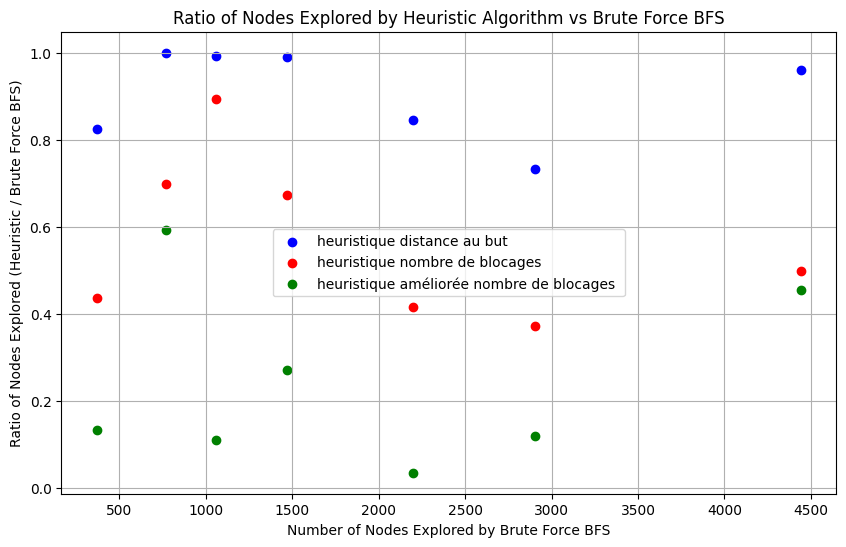

In [29]:
# Extract data
nb_explored_heuristic_distance = [d["nb_explored"] for d in data[0]]
nb_explored_heuristic_nb_blocking = [d["nb_explored"] for d in data[1]]
nb_explored_heuristic_improved= [d["nb_explored"] for d in data[2]]
nb_explored_brute = [d["nb_explored"] for d in data[3]]

# Calculate ratio
ratios_distance = [h / b for h, b in zip(nb_explored_heuristic_distance, nb_explored_brute)]
ratios_nb_blocking = [h / b for h, b in zip(nb_explored_heuristic_nb_blocking, nb_explored_brute)]
ratios_improved = [h / b for h, b in zip(nb_explored_heuristic_improved, nb_explored_brute)]


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(nb_explored_brute, ratios_distance, marker='o', linestyle='-', color='b', label="heuristique distance au but")
plt.scatter(nb_explored_brute, ratios_nb_blocking, marker='o', linestyle='-', color='r', label="heuristique nombre de blocages")
plt.scatter(nb_explored_brute, ratios_improved, marker='o', linestyle='-', color='g', label="heuristique améliorée nombre de blocages ")
plt.xlabel('Number of Nodes Explored by Brute Force BFS')
plt.ylabel('Ratio of Nodes Explored (Heuristic / Brute Force BFS)')
plt.title('Ratio of Nodes Explored by Heuristic Algorithm vs Brute Force BFS')
plt.grid(True)
plt.legend()

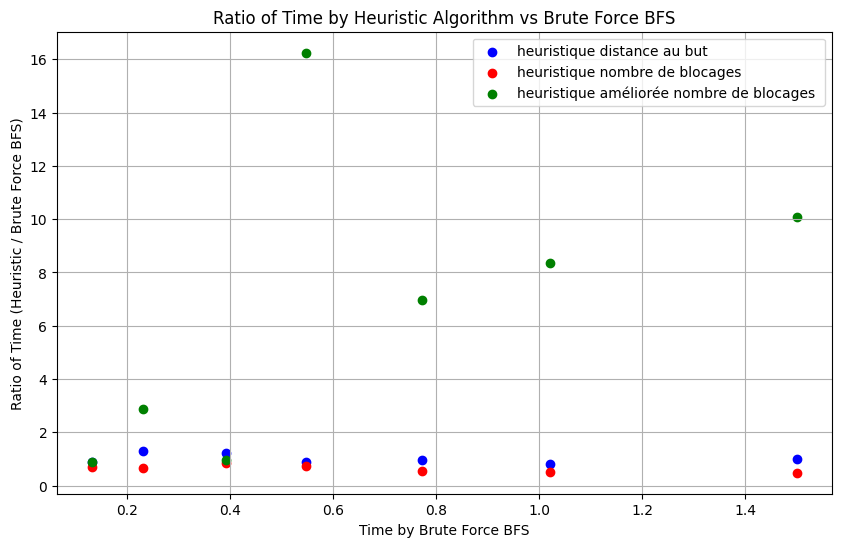

In [30]:
# Extract data
time_heuristic_distance = [d["time"] for d in data[0]]
time_heuristic_nb_blocking = [d["time"] for d in data[1]]
time_heuristic_improved= [d["time"] for d in data[2]]
time_brute = [d["time"] for d in data[3]]

# Calculate ratio
ratios_distance = [h / b for h, b in zip(time_heuristic_distance, time_brute)]
ratios_nb_blocking = [h / b for h, b in zip(time_heuristic_nb_blocking, time_brute)]
ratios_improved = [h / b for h, b in zip(time_heuristic_improved, time_brute)]


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(time_brute, ratios_distance, marker='o', linestyle='-', color='b', label="heuristique distance au but")
plt.scatter(time_brute, ratios_nb_blocking, marker='o', linestyle='-', color='r', label="heuristique nombre de blocages")
plt.scatter(time_brute, ratios_improved, marker='o', linestyle='-', color='g', label="heuristique améliorée nombre de blocages ")
plt.xlabel('Time by Brute Force BFS')
plt.ylabel('Ratio of Time (Heuristic / Brute Force BFS)')
plt.title('Ratio of Time by Heuristic Algorithm vs Brute Force BFS')
plt.grid(True)
plt.legend()